# Report: Collaboration and Competition

0. [Environment Setup](#0)
    - [0.1 Start the Environment](#0.1)
    - [0.2 Examine the State and Action Spaces](#0.2)

1. [Learning Algorithm](#1)
	- [1.1 Actor & Critic Model](#1.1)
	- [1.2 DDPG Agent](#1.2)
    - [1.3 Train with MADDPG](#1.3)
    - [1.4 Train & Play My Agent](#1.4) 

2. [Plot of Rewards](#2)
    - [2.1 Plot](#2.1)
    - [2.2 Play with the Trained Model](#2.2) 

3. [Problems & Puzzles](#3)

4. [Ideas for Future Work](#4)

## 0. Environment Setup 

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

### 2. Examine the State and Action Spaces

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


<a name="1"></a>
# 1. Learning Algorithm
---

<a name="1.1"></a>
## 1.1 Actor & Critic Model

**Actor Architecture**

|Name|Layer|Size|
|:--:|:---:|---:|
|`bn0`|Batch Normalization|state_size|
|`fc1`|Fully Connected + ReLU|state_size -> 128|
|`bn1`|Batch Normalization|128|
|`fc2`|Fully Connected + ReLU|128 -> 64|
|`bn2`|Batch Normalization|64|
|`fc3`|Fully Connected + tanh|64 -> action_size|

**Critic Architecture**

|name|Layer|Size|
|:--:|:---:|---:|
|`bn0`|Batch Normalization|state_size|
|`fcs1`|Fully Connected + ReLU|state_size -> 128|
|-|concatenate treated states with actions|128 -> 128+action_size|
|`fc2`|Fully Connected + ReLU|128+action_size -> 32|
|`fc3`|Fully Connected|32 -> 1|

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.bn0(state)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed,fcs1_units=128, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        state = self.bn0(state)
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

---
<a name="1.2"></a>
## 1.2 DDPG Agent

Here I add `add_id()` function in `DDPGAgent` class for future use in MADDPG training. Other functions in `DDPGAgent`, `OUNoise` and `ReplayBuffer` almost remains the same as Project 2.

In [4]:
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            num_agents (int): number of agents
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.device = DEVICE
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.tau = TAU
            
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(DEVICE)
        self.actor_target = Actor(state_size, action_size, random_seed).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(DEVICE)
        self.critic_target = Critic(state_size, action_size, random_seed).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed) 

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, DEVICE)
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn"""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, noise=0.0):
        """Returns actions for given state as per current policy"""
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += noise*self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples
        q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done)
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
    
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, next_actions)
        # Compute Q targets for current states (y_i)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        # Compute critic loss
        q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        predicted_actions = self.actor_local(states)
        actor_loss = -self.critic_local(states, predicted_actions).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(
                tau * local_param.data + (1.0 - tau) * target_param.data)
    
    def add_id(self, states):
        """Add (i+1) at the end of the states of the i-th agent as its id number."""
        states_with_id = [np.concatenate([s, [i+1]]) for i,s in enumerate(states)]
        return np.vstack(states_with_id)
     
    def save_progress(self):
        """Save the most recent weights of local actor and critic."""
        torch.save(self.actor_local.state_dict(), './Model_Weights/checkpoint_actor.pth')      
        torch.save(self.critic_local.state_dict(), './Model_Weights/checkpoint_critic.pth')
    

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        #dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(len(x))
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        device = self.device
    
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

---
<a name="1.3"></a>
## 1.3 Train with MADDPG

**important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- State from the i-th agent is added an id, here is i+1, at the end of the state array. Thus give the information of the agent while learning.

- The two agents share the same actor and critic network, but each receive their own observations.

In [5]:
def maddpg(agent, num_agents, n_episodes = 3000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []

    # amplitude of OU noise, this slowly decreases to 0
    noise = 2.0
    noise_reduction = 0.9999
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = agent.add_id(env_info.vector_observations) # get the current state
        agent.reset()  # reset the agent
        scores_i = np.zeros(num_agents) # initialize scores for this episode
        while True:
            # get experiences (for each agent)
            actions = agent.act(states, noise)  # select actions
            env_info = env.step(actions)[brain_name]  # send all actions to the environment
            next_states = agent.add_id(env_info.vector_observations)  # get the next states
            rewards = env_info.rewards  # get reward
            dones = env_info.local_done # see if episode finished
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            states = next_states  # roll over states
            scores_i += env_info.rewards # update the score
            noise *= noise_reduction   # reduce noise
            if np.all(dones): # exit loop if episode finished
                break
        
        # save model weights after update per episode
        agent.save_progress()

        # save average of the most recent average scores (max over agents)       
        scores_deque.append(max(scores_i))             
        scores.append(max(scores_i))
        
        # display training progress
        print('\rEpisode {}\tAverage Score (max over agents): {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            noise *= noise_reduction 
            print('\rEpisode {}\tAverage Score (max over agents): {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 1.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            break

    return scores

In [6]:
# Creat a DDPG agent for training
agent = DDPGAgent(state_size=state_size+1, action_size=action_size, random_seed=12345) 
# Train with MADDPG
scores = maddpg(agent, num_agents=2)

Episode 100	Average Score (max over agents): 0.002
Episode 200	Average Score (max over agents): 0.013
Episode 300	Average Score (max over agents): 0.029
Episode 400	Average Score (max over agents): 0.087
Episode 500	Average Score (max over agents): 0.135
Episode 600	Average Score (max over agents): 0.946
Episode 609	Average Score (max over agents): 1.022
Environment solved in 609 episodes!	Average Score: 1.022


<a name="2"></a>
# 2. Plot of Rewards
---

## 2.1 Plot

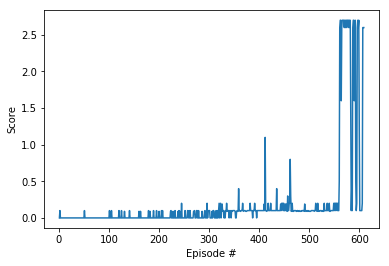

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('./imgs/maddpg_rewards.png')

<a name="2.2"></a>
## 2.2 Play with the trained agent

In [8]:
# creat a new agent to test trained model
agent_test = DDPGAgent(state_size=state_size+1, action_size=action_size, random_seed=12345)
# load trained weights
agent_test.actor_local.load_state_dict(torch.load('./Model_Weights/checkpoint_actor.pth'))
agent_test.critic_local.load_state_dict(torch.load('./Model_Weights/checkpoint_critic.pth'))

# test training result
scores = []
for i in range(100):                                                          # play game for 100 episodes
    env_info = env.reset(train_mode=False)[brain_name]                        # reset the environment    
    states = agent_test.add_id(env_info.vector_observations)                  # get the current state (for each agent)
    scores_i = np.zeros(num_agents)                                           # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                                    # select an action (for each agent)
        env_info = env.step(actions)[brain_name]                              # send all actions to tne environment
        next_states = agent_test.add_id(env_info.vector_observations)         # get next state (for each agent)
        rewards = env_info.rewards                                            # get reward (for each agent)
        dones = env_info.local_done                                           # see if episode finished
        scores_i += env_info.rewards                                          # update the score (for each agent)
        states = next_states                                                  # roll over states to next time step
        if np.any(dones):                                                     # exit loop if episode finished
            break
    print('\rEpisode {}\tAverage Score(max over agents): {:.2f}'.format(i+1, max(scores_i)), end="")
    scores.append(max(scores_i))
print('\rAverage score(max over agents) over 100 episodes: {}'.format(np.mean(scores)))    

Average score(max over agents) over 100 episodes: 2.369000035300851


In [9]:
env.close()

<a name="3"></a>
# 3. Problems & Puzzles
---
**Question about Critic Network in MADDPG**

Refer to the workspace example in lessons, I set the input `states_full` and `actions_full` to the Critic network with size of `(state_size*num_agents, action_size*numagent)` at first. Which meant to input the concatenated states of all agents, as well as actions, to the Critic network every time we update the Critic&Actor. However the scores remained around 0.01 even after 3000 episodes. That's why I just set the Critic input size as `(state_size+1, action_size)` here and input `states`&`Actions` to the Critic agent by agent. I'm confused about when to use `states_full, actions_full` and when to use`states, actions` as the input of the Critic.

<a name="4"></a>
# 4. Ideas of Future Work
---
Tuning the parameters of Model Network, especially Actor, to speed up the computation of action selection.